In [1]:
!pip install evaluate rouge rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=0d36d19fbdd63d46055407ad3630cd5bef6ee2e64cbf5825c3ae6cd2234f9977
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
import torch,nltk,spacy,string,transformers,json,evaluate,warnings
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore")

In [7]:
# nltk.download('punkt')          # Tokenizer models
# nltk.download('wordnet')        # WordNet lexical database
# nltk.download('omw-1.4')        # Open Multilingual WordNet
# nltk.download('averaged_perceptron_tagger')  # POS tagger
# nltk.download('stopwords')      # Common stop words
# nltk.download('vader_lexicon')  # Sentiment analysis lexicon

In [3]:
TOKENIZER = T5TokenizerFast.from_pretrained("t5-small")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL = T5ForConditionalGeneration.from_pretrained("t5-small", return_dict=True)
MODEL.to(DEVICE)
OPTIMIZER = Adam(MODEL.parameters(), lr=0.00001)
Q_LEN = 256   # Question Length
T_LEN = 32    # Target Length
BATCH_SIZE = 4
EPOCHS = 5
OUTPUT_DIR = '/kaggle/tmp/'
OUTPUT_MODEL_NAME = 'AQG-finetuned-squad-lite'

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [4]:
# Loading the data

with open('/kaggle/input/squad-20/train-v2.0.json') as f:
    data = json.load(f)

In [5]:
# Extracting context, question, and answers from the dataset

def prepare_data(data):
    articles = []
    
    for article in data["data"]:
        for paragraph in article["paragraphs"]:
            for qa in paragraph["qas"]:
                question = qa["question"]

                if not qa["is_impossible"]:
                    answer = qa["answers"][0]["text"]
                
                inputs = {"context": paragraph["context"], "question": question, "answer": answer}

            
                articles.append(inputs)

    return articles

In [6]:
data = prepare_data(data)

# Create a Dataframe
data = pd.DataFrame(data)
data

,context,question,answer
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas"
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s
...,...,...,...
130314,"The term ""matter"" is used throughout physics i...",Physics has broadly agreed on the definition o...,Kathmandu Metropolitan City
130315,"The term ""matter"" is used throughout physics i...",Who coined the term partonic matter?,Kathmandu Metropolitan City
130316,"The term ""matter"" is used throughout physics i...",What is another name for anti-matter?,Kathmandu Metropolitan City
130317,"The term ""matter"" is used throughout physics i...",Matter usually does not need to be used in con...,Kathmandu Metropolitan City


In [7]:
# data = data.sample(n=1000, random_state=42)
# data = data.reset_index(drop=True)
data, test_data = train_test_split(data, test_size=0.1, random_state=42)

data = data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print(f"Data size: {len(data)}")
print(f"Testing data size: {len(test_data)}")

Data size: 117287
Testing data size: 13032


In [8]:
class QA_Dataset(Dataset):
    def __init__(self, tokenizer, dataframe, q_len, t_len):
        self.tokenizer = tokenizer
        self.q_len = q_len
        self.t_len = t_len
        self.data = dataframe
        self.questions = self.data["question"]
        self.context = self.data["context"]
        self.answer = self.data['answer']
        
    def __len__(self):
        return len(self.questions)
    
    def __getitem__(self, idx):
        question = self.questions[idx]
        context = self.context[idx]
        answer = self.answer[idx]
        
        question_tokenized = self.tokenizer(question, context, max_length=self.q_len, padding="max_length",
                                                    truncation=True, pad_to_max_length=True, add_special_tokens=True)
        answer_tokenized = self.tokenizer(answer, max_length=self.t_len, padding="max_length", 
                                          truncation=True, pad_to_max_length=True, add_special_tokens=True)
        
        labels = torch.tensor(answer_tokenized["input_ids"], dtype=torch.long)
        labels[labels == 0] = -100
        
        return {
            "input_ids": torch.tensor(question_tokenized["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(question_tokenized["attention_mask"], dtype=torch.long),
            "labels": labels,
            "decoder_attention_mask": torch.tensor(answer_tokenized["attention_mask"], dtype=torch.long)
        }

In [9]:
# Dataloader
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_sampler = RandomSampler(train_data.index)
val_sampler = RandomSampler(val_data.index)

qa_dataset = QA_Dataset(TOKENIZER, data, Q_LEN, T_LEN)

train_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

In [10]:
print(len(train_loader),len(val_loader))

23458 5865


In [11]:
# Lists to store loss values for each epoch
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    MODEL.train()
    train_loss = 0
    train_batch_count = 0
    
    for batch in tqdm(train_loader, desc="Training batches"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        decoder_attention_mask = batch["decoder_attention_mask"].to(DEVICE)

        outputs = MODEL(
                          input_ids=input_ids,
                          attention_mask=attention_mask,
                          labels=labels,
                          decoder_attention_mask=decoder_attention_mask
                        )

        OPTIMIZER.zero_grad()
        outputs.loss.backward()
        OPTIMIZER.step()
        train_loss += outputs.loss.item()
        train_batch_count += 1

    avg_train_loss = train_loss / train_batch_count
    train_losses.append(avg_train_loss)

    # Evaluation
    MODEL.eval()
    val_loss = 0
    val_batch_count = 0

    for batch in tqdm(val_loader, desc="Validation batches"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        decoder_attention_mask = batch["decoder_attention_mask"].to(DEVICE)

        outputs = MODEL(
                          input_ids=input_ids,
                          attention_mask=attention_mask,
                          labels=labels,
                          decoder_attention_mask=decoder_attention_mask
                        )

        val_loss += outputs.loss.item()
        val_batch_count += 1

    avg_val_loss = val_loss / val_batch_count
    val_losses.append(avg_val_loss)
    
    print(f"{epoch+1}/{EPOCHS} -> Train loss: {avg_train_loss}\tValidation loss: {avg_val_loss}")

Validation batches: 100%|██████████| 5865/5865 [02:35<00:00, 37.64it/s]


1/5 -> Train loss: 1.1189594213173564	Validation loss: 0.8407456462804263


Validation batches: 100%|██████████| 5865/5865 [02:35<00:00, 37.60it/s]


2/5 -> Train loss: 0.9320264687225374	Validation loss: 0.7674922537827151


Validation batches: 100%|██████████| 5865/5865 [02:36<00:00, 37.56it/s]


3/5 -> Train loss: 0.8761800763310235	Validation loss: 0.7108982513684903


Validation batches: 100%|██████████| 5865/5865 [02:36<00:00, 37.58it/s]


4/5 -> Train loss: 0.8337906811965039	Validation loss: 0.6684259339004679


Validation batches: 100%|██████████| 5865/5865 [02:35<00:00, 37.65it/s]

5/5 -> Train loss: 0.7965311247309764	Validation loss: 0.630813964347864


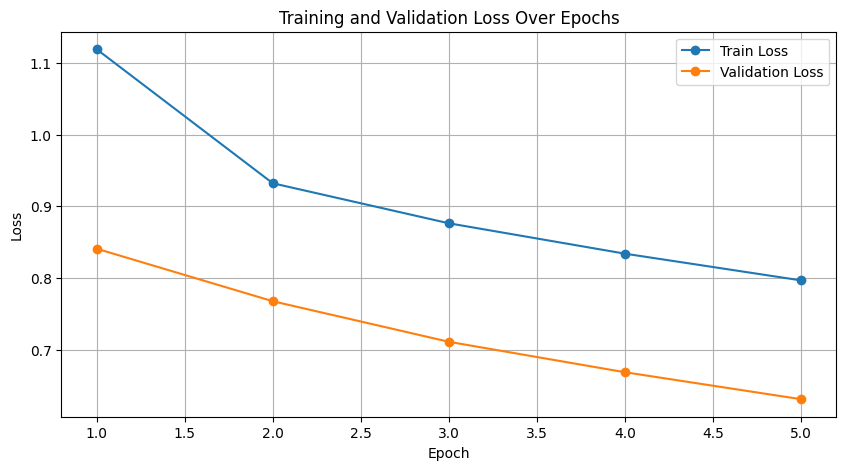

In [13]:
# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
MODEL.save_pretrained(f'{OUTPUT_DIR}{OUTPUT_MODEL_NAME}')
TOKENIZER.save_pretrained(f'{OUTPUT_DIR}{OUTPUT_MODEL_NAME}')

('/kaggle/tmp/AQG-finetuned-squad-lite/tokenizer_config.json',
 '/kaggle/tmp/AQG-finetuned-squad-lite/special_tokens_map.json',
 '/kaggle/tmp/AQG-finetuned-squad-lite/spiece.model',
 '/kaggle/tmp/AQG-finetuned-squad-lite/added_tokens.json',
 '/kaggle/tmp/AQG-finetuned-squad-lite/tokenizer.json')

In [15]:
from huggingface_hub import notebook_login

notebook_login()

In [16]:
# Save the fine-tuned model and tokenizer locally
MODEL.save_pretrained("T5-QuestionAnswering-squad")
TOKENIZER.save_pretrained("T5-QuestionAnswering-squad")

('T5-QuestionAnswering-squad/tokenizer_config.json',
 'T5-QuestionAnswering-squad/special_tokens_map.json',
 'T5-QuestionAnswering-squad/spiece.model',
 'T5-QuestionAnswering-squad/added_tokens.json',
 'T5-QuestionAnswering-squad/tokenizer.json')

In [18]:
from transformers import T5ForConditionalGeneration

# Create your model card details
MODEL.push_to_hub("aayeshanakarmi/T5-QuestionAnswering-squad", use_temp_dir=False)
TOKENIZER.push_to_hub("aayeshanakarmi/T5-QuestionAnswering-squad", use_temp_dir=False)

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aayeshanakarmi/T5-QuestionAnswering-squad/commit/6c254dd9814189e68df4b0602642cac26dd3fe69', commit_message='Upload tokenizer', commit_description='', oid='6c254dd9814189e68df4b0602642cac26dd3fe69', pr_url=None, pr_revision=None, pr_num=None)

In [32]:
bleu_metric = evaluate.load("bleu",trust_remote_code=True)
rouge_metric = evaluate.load("rouge",trust_remote_code=True)
# meteor_metric = evaluate.load("meteor",trust_remote_code=True)

def predict_answer(context, question, ref_answer=None):
    inputs = TOKENIZER(question, context, max_length=Q_LEN, padding="max_length", truncation=True, add_special_tokens=True)
    
    input_ids = torch.tensor(inputs["input_ids"], dtype=torch.long).to(DEVICE).unsqueeze(0)
    attention_mask = torch.tensor(inputs["attention_mask"], dtype=torch.long).to(DEVICE).unsqueeze(0)

    outputs = MODEL.generate(input_ids=input_ids, attention_mask=attention_mask)
    predicted_answer = TOKENIZER.decode(outputs[0], skip_special_tokens=True)

    results = {
        "Context": context,
        "Question": question,
        "Ref Answer": ref_answer,
        "Predicted Answer": predicted_answer
    }

    if ref_answer:
        # Compute BLEU score
        ref_answer_tokens = ref_answer.split()  # Tokenize the reference answer
        predicted_answer_tokens = predicted_answer.split()  # Tokenize the predicted answer
        sentence_bleu_score = sentence_bleu([ref_answer_tokens], predicted_answer_tokens)
        results["Sentence BLEU Score"] = sentence_bleu_score

        # Compute ROUGE scores
        rouge_scores = rouge_metric.compute(predictions=[predicted_answer], references=[ref_answer])
        results["ROUGE-1 Score"] = rouge_scores['rouge1']
        results["ROUGE-2 Score"] = rouge_scores['rouge2']
        results["ROUGE-L Score"] = rouge_scores['rougeL']
        results["ROUGE-W Score"] = rouge_scores.get('rougeW', 0)  # ROUGE-W may not be available in some implementations
        results["ROUGE-S Score"] = rouge_scores.get('rougeS', 0)  # ROUGE-S may not be available in some implementations
        results["ROUGE-SU Score"] = rouge_scores.get('rougeSU', 0)  # ROUGE-SU may not be available in some implementations

        # Compute METEOR score
#         meteor_score_value = meteor_metric.compute(predictions=[predicted_answer], references=ref_answer) if ref_answer else 0
#         results["METEOR Score"] = meteor_score_value

        # Compute F1 score (for GLUE-like evaluation)
        f1 = f1_score([ref_answer], [predicted_answer], average='weighted')
        results["GLUE Score (F1)"] = f1

    return results

In [33]:
context = data.iloc[0]["context"]
question = data.iloc[0]["question"]
answer = data.iloc[0]["answer"]
predict_answer(context, question, answer)

{'Context': 'Tobacco was one of the first major industries to develop after the Civil War. Many farmers grew some tobacco, and the invention of the cigarette made the product especially popular. Winston-Salem is the birthplace of R. J. Reynolds Tobacco Company (RJR), founded by R. J. Reynolds in 1874 as one of 16 tobacco companies in the town. By 1914 it was selling 425 million packs of Camels a year. Today it is the second-largest tobacco company in the U.S. (behind Altria Group). RJR is an indirect wholly owned subsidiary of Reynolds American Inc., which in turn is 42% owned by British American Tobacco.',
 'Question': 'How many packs of camel cigarettes were sold per year in 1914?',
 'Ref Answer': '425 million',
 'Predicted Answer': '425 million',
 'Sentence BLEU Score': 1.0,
 'ROUGE-1 Score': 1.0,
 'ROUGE-2 Score': 1.0,
 'ROUGE-L Score': 1.0,
 'ROUGE-W Score': 0,
 'ROUGE-S Score': 0,
 'ROUGE-SU Score': 0,
 'GLUE Score (F1)': 1.0}

In [38]:
context = test_data.iloc[0]["context"]
question = test_data.iloc[0]["question"]
answer = test_data.iloc[0]["answer"]
predict_answer(context, question, answer)

{'Context': 'It threatened the collapse of large financial institutions, which was prevented by the bailout of banks by national governments, but stock markets still dropped worldwide. In many areas, the housing market also suffered, resulting in evictions, foreclosures and prolonged unemployment. The crisis played a significant role in the failure of key businesses, declines in consumer wealth estimated in trillions of U.S. dollars, and a downturn in economic activity leading to the 2008–2012 global recession and contributing to the European sovereign-debt crisis. The active phase of the crisis, which manifested as a liquidity crisis, can be dated from August 9, 2007, when BNP Paribas terminated withdrawals from three hedge funds citing "a complete evaporation of liquidity".',
 'Question': 'What year did the global recession that followed the financial crisis of 2007 end?',
 'Ref Answer': '2012',
 'Predicted Answer': '2008',
 'Sentence BLEU Score': 0,
 'ROUGE-1 Score': 0.0,
 'ROUGE-2 

In [37]:
context = "The Great Wall of China is a series of fortifications made of various materials, built along the northern borders of China to protect against invasions. It stretches over 13,000 miles and was constructed over several dynasties, starting from the 7th century BC."
question = "What is the purpose of the Great Wall of China?"
predict_answer(context, question, answer)

{'Context': 'The Great Wall of China is a series of fortifications made of various materials, built along the northern borders of China to protect against invasions. It stretches over 13,000 miles and was constructed over several dynasties, starting from the 7th century BC.',
 'Question': 'What is the purpose of the Great Wall of China?',
 'Ref Answer': '2012',
 'Predicted Answer': 'protect against invasions',
 'Sentence BLEU Score': 0,
 'ROUGE-1 Score': 0.0,
 'ROUGE-2 Score': 0.0,
 'ROUGE-L Score': 0.0,
 'ROUGE-W Score': 0,
 'ROUGE-S Score': 0,
 'ROUGE-SU Score': 0,
 'GLUE Score (F1)': 0.0}

In [ ]:
The Great Wall of China is a series of fortifications made of various materials, built along the northern borders of China to protect against invasions. It stretches over 13,000 miles and was constructed over several dynasties, starting from the 7th century BC."

In [22]:
# Initialize lists to store metric scores and metadata
results_list = []
bleu_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
rougeW_scores = []
rougeS_scores = []
rougeSU_scores = []
f1_scores = []
meteor_scores = []

# Iterate through test data
for idx in tqdm(range(len(test_data))):
    context = test_data.iloc[idx]["context"]
    question = test_data.iloc[idx]["question"]
    ref_answer = test_data.iloc[idx]["answer"]
    
    metrics = predict_answer(context, question, ref_answer)
    
    if ref_answer:
        # Append metrics to lists
        bleu_scores.append(metrics.get("Sentence BLEU Score", 0))
        rouge1_scores.append(metrics.get("ROUGE-1 Score", 0))
        rouge2_scores.append(metrics.get("ROUGE-2 Score", 0))
        rougeL_scores.append(metrics.get("ROUGE-L Score", 0))
        rougeW_scores.append(metrics.get("ROUGE-W Score", 0))
        rougeS_scores.append(metrics.get("ROUGE-S Score", 0))
        rougeSU_scores.append(metrics.get("ROUGE-SU Score", 0))
        f1_scores.append(metrics.get("GLUE Score (F1)", 0))
        meteor_scores.append(metrics.get("METEOR Score", 0))
        
        # Append all data to results list
        results_list.append({
            "ID": idx,
            "Context": context,
            "Question": question,
            "Ref Answer": ref_answer,
            "Predicted Answer": metrics.get("Predicted Answer", ""),
            "Sentence BLEU Score": metrics.get("Sentence BLEU Score", 0),
            "ROUGE-1 Score": metrics.get("ROUGE-1 Score", 0),
            "ROUGE-2 Score": metrics.get("ROUGE-2 Score", 0),
            "ROUGE-L Score": metrics.get("ROUGE-L Score", 0),
            "ROUGE-W Score": metrics.get("ROUGE-W Score", 0),
            "ROUGE-S Score": metrics.get("ROUGE-S Score", 0),
            "ROUGE-SU Score": metrics.get("ROUGE-SU Score", 0),
            "METEOR Score": metrics.get("METEOR Score", 0),
            "GLUE Score (F1)": metrics.get("GLUE Score (F1)", 0)
        })

# Convert results to DataFrame and save to CSV
results_df = pd.DataFrame(results_list)
results_df.to_csv('model_evaluation_results.csv', index=False)

# Calculate average, std, max, and min
def compute_stats(scores):
    return np.mean(scores), np.std(scores), np.max(scores), np.min(scores)

avg_bleu, std_bleu, max_bleu, min_bleu = compute_stats(bleu_scores)
avg_rouge1, std_rouge1, max_rouge1, min_rouge1 = compute_stats(rouge1_scores)
avg_rouge2, std_rouge2, max_rouge2, min_rouge2 = compute_stats(rouge2_scores)
avg_rougeL, std_rougeL, max_rougeL, min_rougeL = compute_stats(rougeL_scores)
avg_rougeW, std_rougeW, max_rougeW, min_rougeW = compute_stats(rougeW_scores)
avg_rougeS, std_rougeS, max_rougeS, min_rougeS = compute_stats(rougeS_scores)
avg_rougeSU, std_rougeSU, max_rougeSU, min_rougeSU = compute_stats(rougeSU_scores)
avg_f1, std_f1, max_f1, min_f1 = compute_stats(f1_scores)
avg_meteor, std_meteor, max_meteor, min_meteor = compute_stats(meteor_scores)

# Print results
print(f"Average BLEU Score: {avg_bleu:.4f}, Std Dev: {std_bleu:.4f}, Max: {max_bleu:.4f}, Min: {min_bleu:.4f}")
print(f"Average ROUGE-1 Score: {avg_rouge1:.4f}, Std Dev: {std_rouge1:.4f}, Max: {max_rouge1:.4f}, Min: {min_rouge1:.4f}")
print(f"Average ROUGE-2 Score: {avg_rouge2:.4f}, Std Dev: {std_rouge2:.4f}, Max: {max_rouge2:.4f}, Min: {min_rouge2:.4f}")
print(f"Average ROUGE-L Score: {avg_rougeL:.4f}, Std Dev: {std_rougeL:.4f}, Max: {max_rougeL:.4f}, Min: {min_rougeL:.4f}")
print(f"Average ROUGE-W Score: {avg_rougeW:.4f}, Std Dev: {std_rougeW:.4f}, Max: {max_rougeW:.4f}, Min: {min_rougeW:.4f}")
print(f"Average ROUGE-S Score: {avg_rougeS:.4f}, Std Dev: {std_rougeS:.4f}, Max: {max_rougeS:.4f}, Min: {min_rougeS:.4f}")
print(f"Average ROUGE-SU Score: {avg_rougeSU:.4f}, Std Dev: {std_rougeSU:.4f}, Max: {max_rougeSU:.4f}, Min: {min_rougeSU:.4f}")
print(f"Average METEOR Score: {avg_meteor:.4f}, Std Dev: {std_meteor:.4f}, Max: {max_meteor:.4f}, Min: {min_meteor:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}, Std Dev: {std_f1:.4f}, Max: {max_f1:.4f}, Min: {min_f1:.4f}")

 23%|██▎       | 2999/13032 [15:36<50:29,  3.31it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 13032/13032 [1:07:33<00:00,  3.22it/s]


Average BLEU Score: 0.5462, Std Dev: 0.4596, Max: 1.0000, Min: 0.0000
Average ROUGE-1 Score: 0.5707, Std Dev: 0.4532, Max: 1.0000, Min: 0.0000
Average ROUGE-2 Score: 0.3541, Std Dev: 0.4544, Max: 1.0000, Min: 0.0000
Average ROUGE-L Score: 0.5702, Std Dev: 0.4534, Max: 1.0000, Min: 0.0000
Average ROUGE-W Score: 0.0000, Std Dev: 0.0000, Max: 0.0000, Min: 0.0000
Average ROUGE-S Score: 0.0000, Std Dev: 0.0000, Max: 0.0000, Min: 0.0000
Average ROUGE-SU Score: 0.0000, Std Dev: 0.0000, Max: 0.0000, Min: 0.0000
Average METEOR Score: 0.0000, Std Dev: 0.0000, Max: 0.0000, Min: 0.0000
Average F1 Score: 0.4362, Std Dev: 0.4959, Max: 1.0000, Min: 0.0000


In [23]:
def generate_question(context):
    # Prepare input for question generation
    input_text = f"generate question: {context}"
    inputs = TOKENIZER(input_text, max_length=Q_LEN, padding="max_length", truncation=True, add_special_tokens=True)

    input_ids = torch.tensor(inputs["input_ids"], dtype=torch.long).to(DEVICE).unsqueeze(0)
    attention_mask = torch.tensor(inputs["attention_mask"], dtype=torch.long).to(DEVICE).unsqueeze(0)

    # Generate question
    question_ids = MODEL.generate(input_ids=input_ids, attention_mask=attention_mask)
    question = TOKENIZER.decode(question_ids[0], skip_special_tokens=True)

    return question

def generate_answer(context, question):
    # Prepare input for answer generation
    inputs = TOKENIZER(question, context, max_length=Q_LEN, padding="max_length", truncation=True, add_special_tokens=True)

    input_ids = torch.tensor(inputs["input_ids"], dtype=torch.long).to(DEVICE).unsqueeze(0)
    attention_mask = torch.tensor(inputs["attention_mask"], dtype=torch.long).to(DEVICE).unsqueeze(0)

    # Generate answer
    answer_ids = MODEL.generate(input_ids=input_ids, attention_mask=attention_mask)
    answer = TOKENIZER.decode(answer_ids[0], skip_special_tokens=True)

    return answer

# Example usage
context = "The Solar System consists of the Sun and the celestial bodies that orbit it, including eight planets, their moons, and other small solar system bodies."

# Generate question
generated_question = generate_question(context)
print("Generated Question:", generated_question)

# Generate answer based on the generated question
generated_answer = generate_answer(context, generated_question)
print("Generated Answer:", generated_answer)

Generated Question: eight planets, their moons, and other small solar system bodies
Generated Answer: eight planets, their moons, and other small solar system bodies
